In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load file
filename = "enablers_challengers-healthtech_vc_deals_2010-2024.txt"
df = pd.read_csv(filename, delimiter='\t')

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Strip whitespace from string columns only
for col in df.select_dtypes(include='object'):
    df[col] = df[col].map(lambda x: x.strip() if isinstance(x, str) else x)

# Convert amt_raised_millions column to float
df['amt_raised_millions'] = (
    df['amt_raised_millions']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

# Preview
print(df.head())

# Optional: Save as .csv
df.to_csv("enablers_challengers-healthtech_vc_deals_2010-2024.csv", index=False)

                   company  deal_year company_type  amt_raised_millions
0  Accolade (Managed Care)       2010      Enabler                16.94
1    AirStrip Technologies       2010      Enabler                30.00
2                 AltheaDx       2010      Enabler                 6.00
3             Ambra Health       2010      Enabler                11.88
4                 CardioDx       2010   Challenger                35.00


🔍 DATA OVERVIEW
Shape: (3778, 4)
Years: 2010 - 2024
Company types: {'Enabler': 2442, 'Challenger': 1336}
Total funding: $107810.5M


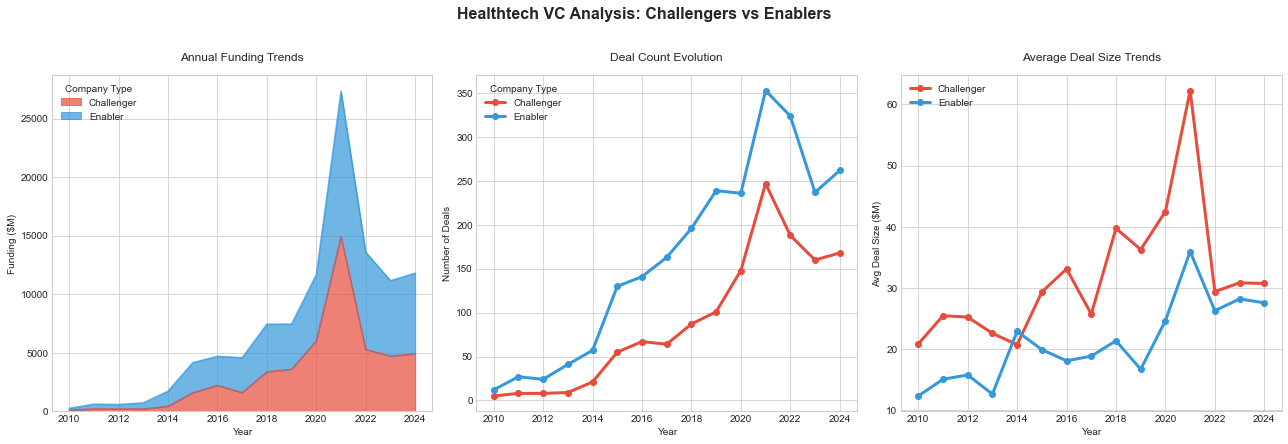


📊 KEY INSIGHTS
2010-2014:
  Deal Ratio (C:E): 0.32:1
  Funding Ratio (C:E): 0.42:1
2015-2019:
  Deal Ratio (C:E): 0.43:1
  Funding Ratio (C:E): 0.77:1
2020-2024:
  Deal Ratio (C:E): 0.65:1
  Funding Ratio (C:E): 0.90:1

Funding Statistics:
• Average Challenger deal: $38.2M
• Average Enabler deal: $24.6M
• Challenger premium: 55.3%


In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Quick data overview
print("🔍 DATA OVERVIEW")
print("="*40)
print(f"Shape: {df.shape}")
print(f"Years: {df['deal_year'].min()} - {df['deal_year'].max()}")
print(f"Company types: {df['company_type'].value_counts().to_dict()}")
print(f"Total funding: ${df['amt_raised_millions'].sum():.1f}M")

# Check for unexpected company types
expected_types = {'Challenger', 'Enabler'}
actual_types = set(df['company_type'].unique())
if not actual_types.issubset(expected_types):
    print(f"Unexpected company types found: {actual_types - expected_types}")

color_map = {'Challenger': '#e74c3c', 'Enabler': '#3498db'}
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Healthtech VC Analysis: Challengers vs Enablers', fontsize=16, fontweight='bold', y=1.02)
plt.subplots_adjust(wspace=0.3)

# Add period column for analysis
df = df.copy()
df['period'] = df['deal_year'].apply(lambda x: '2010-2014' if x <= 2014
                                    else '2015-2019' if x <= 2019
                                    else '2020-2024')

# 1. Annual Funding Trends
ax1 = axes[0]
yearly_funding = df.groupby(['deal_year', 'company_type'])['amt_raised_millions'].sum().reset_index()
yearly_pivot = yearly_funding.pivot(index='deal_year', columns='company_type', values='amt_raised_millions').fillna(0)
yearly_pivot = yearly_pivot.sort_index()

colors = [color_map.get(col, '#999999') for col in yearly_pivot.columns]
yearly_pivot.plot(kind='area', ax=ax1, alpha=0.7, color=colors)
ax1.set_title('Annual Funding Trends', pad=15)
ax1.set_ylabel('Funding ($M)')
ax1.set_xlabel('Year')
ax1.legend(title='Company Type')

# 2. Deal Count Evolution
ax2 = axes[1]
yearly_deals = df.groupby(['deal_year', 'company_type']).size().reset_index(name='deal_count')
yearly_deals_pivot = yearly_deals.pivot(index='deal_year', columns='company_type', values='deal_count').fillna(0)
yearly_deals_pivot = yearly_deals_pivot.sort_index()

colors = [color_map.get(col, '#999999') for col in yearly_deals_pivot.columns]
yearly_deals_pivot.plot(kind='line', ax=ax2, marker='o', linewidth=3, color=colors)
ax2.set_title('Deal Count Evolution', pad=15)
ax2.set_ylabel('Number of Deals')
ax2.set_xlabel('Year')
ax2.legend(title='Company Type')

# 3. Average Deal Size Trends
ax3 = axes[2]
avg_deal_size = df.groupby(['deal_year', 'company_type'])['amt_raised_millions'].mean().reset_index()

for company_type in ['Challenger', 'Enabler']:
    type_data = avg_deal_size[avg_deal_size['company_type'] == company_type]
    color = color_map.get(company_type, '#999999')
    ax3.plot(type_data['deal_year'], type_data['amt_raised_millions'],
             marker='o', linewidth=3, label=company_type, color=color)

ax3.set_title('Average Deal Size Trends', pad=15)
ax3.set_ylabel('Avg Deal Size ($M)')
ax3.set_xlabel('Year')
ax3.legend()

plt.tight_layout()

# Save plots as png
plt.savefig('healthtech_enablers_and_challengers.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            format='png')

plt.show()

# Print key insights
print("\n📊 KEY INSIGHTS")
print("="*40)

for period in ['2010-2014', '2015-2019', '2020-2024']:
    period_data = df[df['period'] == period]
    if len(period_data) > 0:
        challenger_deals = len(period_data[period_data['company_type'] == 'Challenger'])
        enabler_deals = len(period_data[period_data['company_type'] == 'Enabler'])
        deal_ratio = challenger_deals / enabler_deals if enabler_deals > 0 else 0

        challenger_funding = period_data[period_data['company_type'] == 'Challenger']['amt_raised_millions'].sum()
        enabler_funding = period_data[period_data['company_type'] == 'Enabler']['amt_raised_millions'].sum()
        funding_ratio = challenger_funding / enabler_funding if enabler_funding > 0 else 0

        print(f"{period}:")
        print(f"  Deal Ratio (C:E): {deal_ratio:.2f}:1")
        print(f"  Funding Ratio (C:E): {funding_ratio:.2f}:1")

challenger_avg = df[df['company_type'] == 'Challenger']['amt_raised_millions'].mean()
enabler_avg = df[df['company_type'] == 'Enabler']['amt_raised_millions'].mean()

print(f"\nFunding Statistics:")
print(f"• Average Challenger deal: ${challenger_avg:.1f}M")
print(f"• Average Enabler deal: ${enabler_avg:.1f}M")
print(f"• Challenger premium: {(challenger_avg/enabler_avg-1)*100:.1f}%")